In [1]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import collections
import torch
import pathlib

from nltk.metrics.distance  import edit_distance
from IPython.display import display
from clz_or_cls import recovery, analysis

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plt.rcParams['figure.dpi'] = 300
%matplotlib inline

# Aggregate Recovery Statistics for Finetuning Models

In [ ]:
results_csvs = analysis.get_finetuning_results_csvs()
for train, results in results_csvs.items():
    print(train, len(results))

results_csvs

In [6]:
final_result = collections.namedtuple('final_result', ['train', 'test', 'split', 'all_acc', 'leg_acc', 'all_acc_changed', 'leg_acc_changed', 'accent_acc', 'edit_dist_1', 'edit_dist_2', 'edit_dist_3', 'edit_dist_per', 'is_word', 'is_word_changed', 'other_word', 'other_word_changed', 'wrong_word_percent', 'train_word', 'wrong_train_word', 'wrong_train_dist'])
final_result_rows = []

safe_edit = lambda row: int(edit_distance(row['clean'], row['perturbed'])) if type(row['clean']) != float and type(row['perturbed']) != float else np.nan

def safe_true(series):
    value_counts = series.value_counts(normalize=True)
    if True in value_counts:
        return value_counts[True]
    else:
        return 0.0

for train, value in tqdm.tqdm(results_csvs.items()):

    # REMOVE this to analyze everything, which can be quite intensive
    if train not in ['dces', 'ices', 'legit_extended', 'visual', 'visual+phonetic+typo', 'visual+phonetic+typo_full']:
        continue
    for test, path in value.items():
        if test not in ['dces', 'ices', 'legit_extended', 'visual', 'visual+phonetic+typo', 'visual+phonetic+typo_full']:
            continue

        df = pd.read_csv(path)
        train_words = df[df['split'] == 'train']['clean'].unique()
        df['train_word'] = df['recovered'].isin(train_words)
        df['perturbation_distance'] = df.apply(safe_edit, axis=1)
                
        for split in ['train', 'valid', 'test']:
            split_df = df.loc[df['split'] == split]
            split_df_changed = split_df.loc[split_df['perturbation_distance'] > 0]

            all_acc, leg_acc = recovery.analyze_accuracy(split_df)
            all_acc_changed, leg_acc_changed = recovery.analyze_accuracy(split_df_changed)
            accent_acc, _ = recovery.analyze_accuracy(split_df[split_df['non_ascii_clean'] == True])
            edit_dist_1, edit_dist_2, edit_dist_3 = [safe_true(split_df['edit_distance'] <= i) for i in [1, 2, 3]]
            edit_dist_pct = (split_df['edit_distance']/split_df['clean'].str.len()).mean()
            is_word = safe_true(split_df['is_word'])
            is_word_changed = safe_true(split_df_changed['is_word'])
            other_word = safe_true(split_df['other_word'])
            other_word_changed = safe_true(split_df_changed['other_word'])
            wrong_word_percent = safe_true(~split_df['match'] & split_df['is_word'])/(1-all_acc)
            train_word_percent = safe_true(split_df['train_word'])
            wrong_train_word_percent = safe_true(~split_df['match'] & split_df['train_word'])/(1-all_acc)
            wrong_train_dist = split_df[~split_df['match'] & split_df['train_word']]['edit_distance'].mean()

            result = final_result(train, test, split, all_acc, leg_acc, all_acc_changed, leg_acc_changed, accent_acc, edit_dist_1, edit_dist_2, edit_dist_3, edit_dist_pct, is_word, is_word_changed, other_word, other_word_changed, wrong_word_percent, train_word_percent, wrong_train_word_percent, wrong_train_dist)
            final_result_rows.append(result)

results_df = pd.DataFrame(final_result_rows)

def categorize(name):
    if 'ices' in name or 'dces' in name or 'legit' in name:
        return 'visual'
    elif '_phonetic' in name or 'phonee' in name:
        return 'phonetic'
    elif '_typo' in name or 'noise' in name:
        return 'typo'
    elif 'repeated' in name:
        return 'baseline'
    elif 'typo' in name or 'phonetic' in name or 'visual' in name:
        return 'class'
    elif 'mixed' in name:
        return 'mixed'
    else:
        raise ValueError(name)

results_df[results_df['split'] == 'test'].sort_values('edit_dist_1', ascending=False)

  0%|          | 0/47 [00:00<?, ?it/s]

 28%|██▊       | 13/47 [00:08<00:21,  1.60it/s]/tmp/ipykernel_446235/3277611516.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
 64%|██████▍   | 30/47 [00:55<00:38,  2.29s/it]/tmp/ipykernel_446235/3277611516.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
 77%|███████▋  | 36/47 [01:28<00:38,  3.52s/it]/tmp/ipykernel_446235/3277611516.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
100%|██████████| 47/47 [02:01<00:00,  2.58s/it]


,train,test,split,all_acc,leg_acc,all_acc_changed,leg_acc_changed,accent_acc,edit_dist_1,edit_dist_2,edit_dist_3,edit_dist_per,is_word,is_word_changed,other_word,other_word_changed,wrong_word_percent,train_word,wrong_train_word,wrong_train_dist
5,dces,dces,test,0.980311,0.985756,0.979411,0.985067,0.000000,0.999223,1.000000,1.000000,0.003363,0.870596,0.870665,0.008808,0.009120,0.447368,0.003756,0.085526,1.000000
20,legit_extended,legit_extended,test,0.813212,0.877353,0.790613,0.852554,0.052083,0.937047,0.974611,0.989767,0.044581,0.756736,0.742652,0.031088,0.034069,0.166436,0.016969,0.083218,1.841667
50,visual,visual,test,0.789465,0.865067,0.777210,0.853882,0.045139,0.906736,0.956347,0.978886,0.058520,0.756131,0.748895,0.047453,0.049862,0.225390,0.023143,0.101928,2.255533
23,legit_extended,dces,test,0.626813,0.723314,0.603980,0.702222,0.052083,0.872539,0.961917,0.988083,0.083733,0.607902,0.590714,0.046891,0.048915,0.125651,0.022409,0.056578,1.588957
32,ices,ices,test,0.679145,0.760579,0.676740,0.757860,0.041667,0.846891,0.934456,0.974093,0.090528,0.685881,0.684982,0.067487,0.068027,0.210335,0.033679,0.100929,2.256000
41,visual+phonetic+typo_full,visual,test,0.708204,0.790248,0.707136,0.796999,0.076389,0.814162,0.881174,0.930268,0.110623,0.779965,0.774724,0.135838,0.131998,0.465522,0.108938,0.367268,3.114827
17,visual+phonetic+typo,visual,test,0.667271,0.772188,0.660405,0.772327,0.086806,0.795725,0.872625,0.926425,0.121423,0.743351,0.735083,0.138731,0.136786,0.416948,0.095596,0.282637,3.112948
29,ices,dces,test,0.520466,0.610838,0.492331,0.582400,0.041667,0.726554,0.853497,0.921244,0.154496,0.568264,0.549675,0.099741,0.105154,0.207996,0.051295,0.103998,2.675325
53,visual,visual+phonetic+typo_full,test,0.420056,0.492985,0.386107,0.445789,0.050000,0.704241,0.854395,0.924590,0.175806,0.438930,0.414291,0.062228,0.064320,0.107301,0.027884,0.046607,2.423901
26,legit_extended,ices,test,0.406218,0.541548,0.400576,0.534225,0.010417,0.687176,0.854275,0.941839,0.168534,0.437435,0.434066,0.066321,0.066981,0.111693,0.030570,0.049738,2.355263


In [7]:
results_df['train_category'] = results_df['train'].apply(categorize)
results_df['test_category'] = results_df['test'].apply(categorize)
results_df['+'] = results_df['train'].apply(lambda x: x.count('+'))
results_df['%_each_ds_in_train'] = results_df['train'].apply(lambda x: 1 if '+' not in x else (1 if 'full' in x else np.round(1/(x.count('+') + 1), 2)))
results_df['%_each_ds_in_test'] = results_df['test'].apply(lambda x: 1 if '+' not in x else (1 if 'full' in x else np.round(1/(x.count('+') + 1), 2)))

def out_of_domain(row):
    return row['test'].strip() not in row['train'] and row['train'] != 'repeated' and '+' not in row['test']

results_df['acc'] = results_df.apply(lambda row: f"{row['all_acc']:.1%}*" if out_of_domain(row) else f"{row['all_acc']:.1%}", axis=1)
results_df['acc_changed'] = results_df.apply(lambda row: f"{row['all_acc_changed']:.1%}*" if out_of_domain(row) else f"{row['all_acc_changed']:.1%}", axis=1)

results_df['edit'] = results_df.apply(lambda row: f"{row['edit_dist_1']:.1%}*" if out_of_domain(row) else f"{row['edit_dist_1']:.1%}", axis=1)
results_df['train_norm'] = results_df['train'].apply(lambda x: x.replace('_full', ''))
results_df['test_norm'] = results_df['test'].apply(lambda x: x.replace('_full', ''))

In [8]:
results_df[results_df['test'] == 'legit_extended']

,train,test,split,all_acc,leg_acc,all_acc_changed,leg_acc_changed,accent_acc,edit_dist_1,edit_dist_2,...,train_category,test_category,+,%_each_ds_in_train,%_each_ds_in_test,acc,acc_changed,edit,train_norm,test_norm
0,dces,legit_extended,train,0.248859,0.385586,0.143617,0.236355,0.125000,0.518150,0.715930,...,visual,visual,0,1.0,1.0,24.9%*,14.4%*,51.8%*,dces,legit_extended
1,dces,legit_extended,valid,0.233983,0.371272,0.141747,0.239099,0.030000,0.497048,0.703572,...,visual,visual,0,1.0,1.0,23.4%*,14.2%*,49.7%*,dces,legit_extended
2,dces,legit_extended,test,0.224870,0.352430,0.125018,0.208144,0.000000,0.500648,0.701295,...,visual,visual,0,1.0,1.0,22.5%*,12.5%*,50.1%*,dces,legit_extended
18,legit_extended,legit_extended,train,0.999489,0.999675,0.999418,0.999596,1.000000,0.999762,0.999932,...,visual,visual,0,1.0,1.0,99.9%,99.9%,100.0%,legit_extended,legit_extended
19,legit_extended,legit_extended,valid,0.824919,0.885469,0.805491,0.864280,0.140000,0.944051,0.979333,...,visual,visual,0,1.0,1.0,82.5%,80.5%,94.4%,legit_extended,legit_extended
20,legit_extended,legit_extended,test,0.813212,0.877353,0.790613,0.852554,0.052083,0.937047,0.974611,...,visual,visual,0,1.0,1.0,81.3%,79.1%,93.7%,legit_extended,legit_extended
33,ices,legit_extended,train,0.452871,0.621291,0.376650,0.530049,0.255000,0.602908,0.710311,...,visual,visual,0,1.0,1.0,45.3%*,37.7%*,60.3%*,ices,legit_extended
34,ices,legit_extended,valid,0.362858,0.518731,0.293252,0.429974,0.090000,0.540892,0.669767,...,visual,visual,0,1.0,1.0,36.3%*,29.3%*,54.1%*,ices,legit_extended
35,ices,legit_extended,test,0.361917,0.510031,0.288639,0.416287,0.052083,0.538212,0.672539,...,visual,visual,0,1.0,1.0,36.2%*,28.9%*,53.8%*,ices,legit_extended


In [15]:
# Caching hard to calculate results
import datetime
cache_path = pathlib.Path('output')
cache_path.mkdir(exist_ok=True)
results_df.to_csv(cache_path/f'results-{datetime.datetime.now()}.csv', index=False)

In [16]:
test_df = results_df[results_df['split'] == 'test']
test_df[['train', 'test', 'acc', 'leg_acc']].sort_values('test')

,train,test,acc,leg_acc
5,dces,dces,98.0%,0.985756
29,ices,dces,52.0%*,0.610838
23,legit_extended,dces,62.7%*,0.723314
26,legit_extended,ices,40.6%*,0.541548
8,dces,ices,12.4%*,0.201272
32,ices,ices,67.9%,0.760579
35,ices,legit_extended,36.2%*,0.510031
2,dces,legit_extended,22.5%*,0.352430
20,legit_extended,legit_extended,81.3%,0.877353
50,visual,visual,78.9%,0.865067


In [18]:
test_df[['train', 'test', 'all_acc', 'leg_acc']]

,train,test,all_acc,leg_acc
2,dces,legit_extended,0.224870,0.352430
5,dces,dces,0.980311,0.985756
8,dces,ices,0.123705,0.201272
11,visual+phonetic+typo,visual+phonetic+typo,0.560720,0.598180
14,visual+phonetic+typo,visual+phonetic+typo_full,0.568399,0.605709
17,visual+phonetic+typo,visual,0.667271,0.772188
20,legit_extended,legit_extended,0.813212,0.877353
23,legit_extended,dces,0.626813,0.723314
26,legit_extended,ices,0.406218,0.541548
29,ices,dces,0.520466,0.610838


/tmp/ipykernel_446235/2713842287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['acc_diff'] = test_df['leg_acc'] - test_df['all_acc']


<AxesSubplot: >

count    18.000000
mean      0.076939
std       0.038199
min       0.005446
25%       0.044130
50%       0.079500
75%       0.094968
max       0.148114
Name: acc_diff, dtype: float64

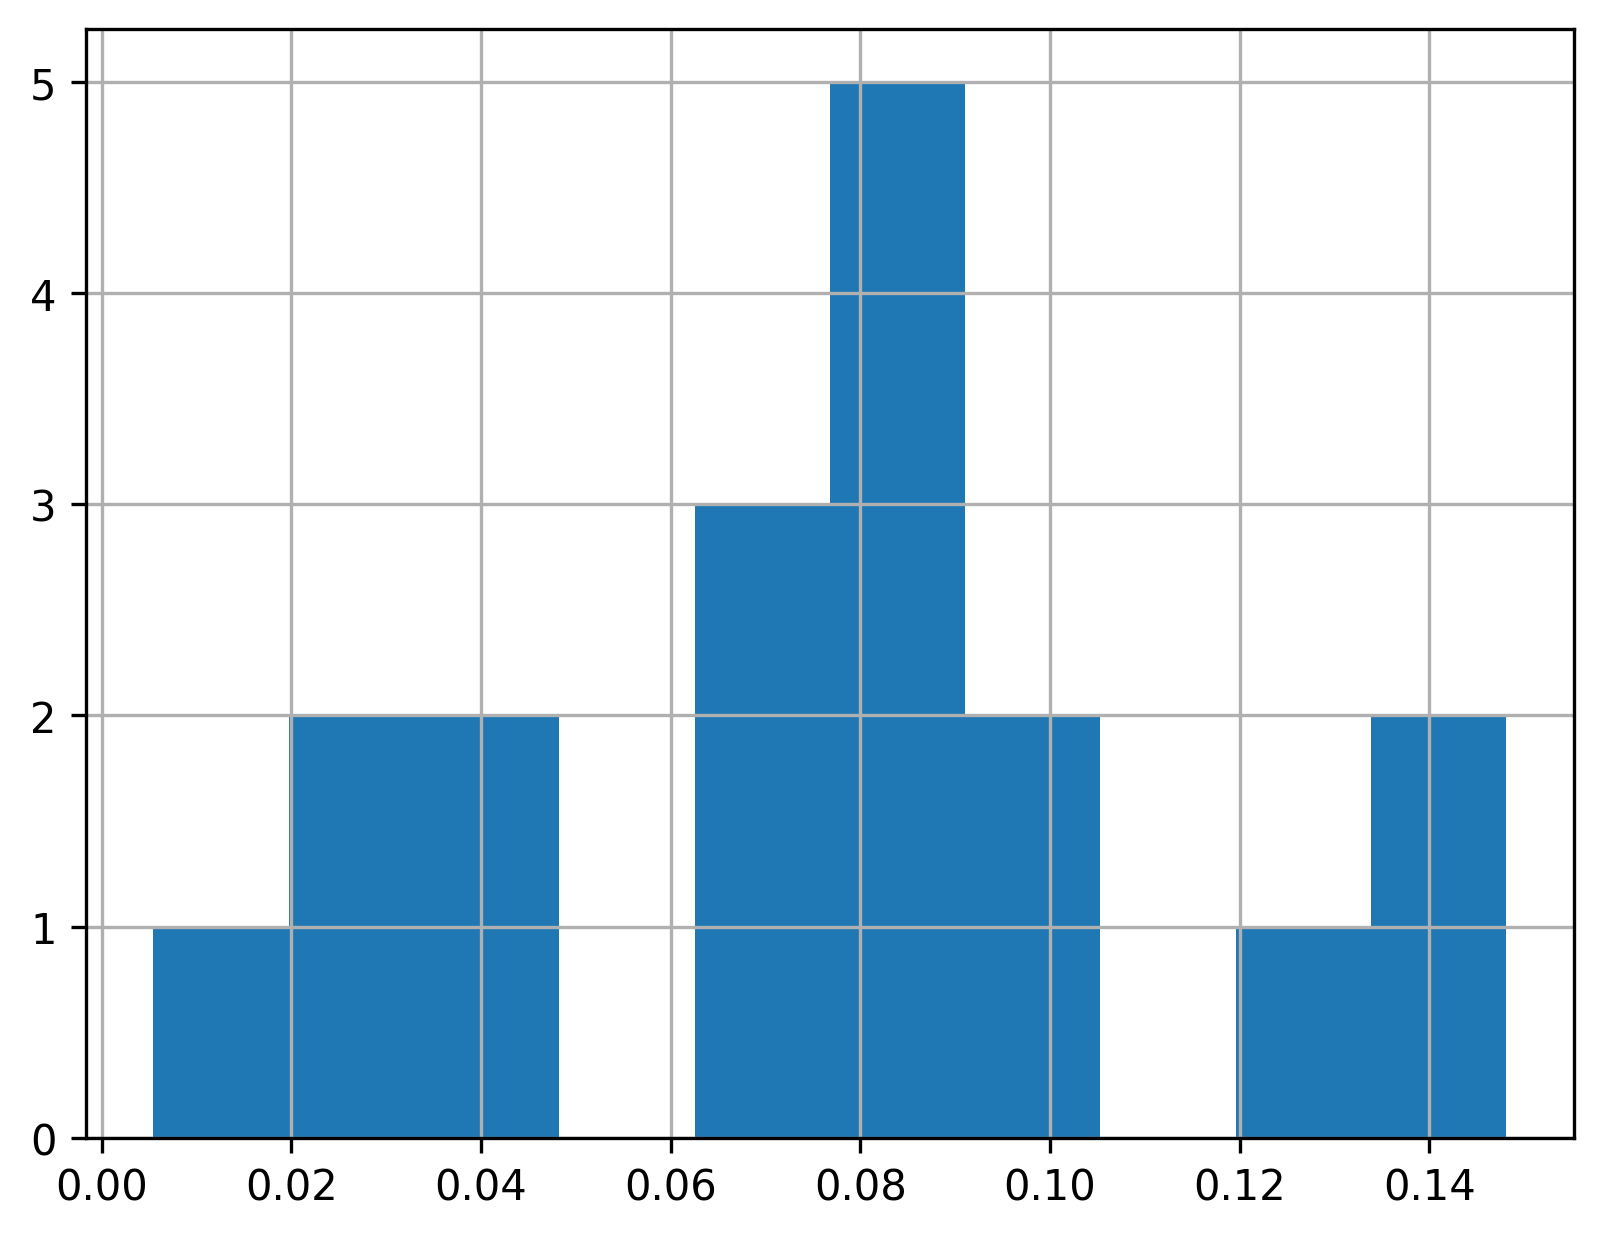

In [19]:
test_df['acc_diff'] = test_df['leg_acc'] - test_df['all_acc'] 
display(test_df['acc_diff'].hist())
test_df['acc_diff'].describe()

In [20]:
test_df.groupby(['test']).mean()['acc_diff'].sort_values(ascending=False)

/tmp/ipykernel_446235/3540962856.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df.groupby(['test']).mean()['acc_diff'].sort_values(ascending=False)


test
legit_extended               0.113271
ices                         0.098110
visual                       0.087521
dces                         0.064106
visual+phonetic+typo         0.051394
visual+phonetic+typo_full    0.047235
Name: acc_diff, dtype: float64

In [22]:
test_df['train_category'].unique()

array(['visual', 'class'], dtype=object)

In [23]:
category_dfs = {}
pd.options.display.float_format = '{:,.1%}'.format
for category in test_df['train_category'].unique():
    q = test_df['train_category'].isin([category, 'baseline'])

    test_sets = set(test_df[q]['train_norm'])
    # test_sets.remove('repeated')
    
    pivot_df = test_df[q & test_df['test_norm'].isin(test_sets)]

    pivot_df.loc[pivot_df['train_norm'] == 'repeated', '+'] = ""
    
    pivot_df = pivot_df[['+', 'train_norm', 'test', 'all_acc', 'acc', 'edit_dist_1', 'edit', '%_each_ds_in_train', 'test_norm', '%_each_ds_in_test']].pivot(index=['+', 'train_norm', '%_each_ds_in_train'], columns=['test_norm', '%_each_ds_in_test'], values=['acc', 'edit'])

    try:
        last_columns = [c for c in pivot_df.columns if '+' in c[1]]
        first_columns = [c for c in pivot_df.columns if c not in last_columns]
        
        pivot_df = pivot_df[first_columns + last_columns]
    except StopIteration:
        print('FAILED')

    if category != 'baseline':
        print(category)
        category_dfs[category] = pivot_df.sort_index(ascending=True)
        display("Accuracy", pivot_df['acc'])#, "Edit Distance 1", pivot_df['edit'])

visual


/tmp/ipykernel_446235/2186692308.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_df = pivot_df[['+', 'train_norm', 'test', 'all_acc', 'acc', 'edit_dist_1', 'edit', '%_each_ds_in_train', 'test_norm', '%_each_ds_in_test']].pivot(index=['+', 'train_norm', '%_each_ds_in_train'], columns=['test_norm', '%_each_ds_in_test'], values=['acc', 'edit'])


'Accuracy'

test_norm                           legit_extended    dces    ices
%_each_ds_in_test                           100.0%  100.0%  100.0%
+ train_norm     %_each_ds_in_train                               
0 dces           100.0%                     22.5%*   98.0%  12.4%*
  ices           100.0%                     36.2%*  52.0%*   67.9%
  legit_extended 100.0%                      81.3%  62.7%*  40.6%*

class


/tmp/ipykernel_446235/2186692308.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_df = pivot_df[['+', 'train_norm', 'test', 'all_acc', 'acc', 'edit_dist_1', 'edit', '%_each_ds_in_train', 'test_norm', '%_each_ds_in_test']].pivot(index=['+', 'train_norm', '%_each_ds_in_train'], columns=['test_norm', '%_each_ds_in_test'], values=['acc', 'edit'])


'Accuracy'

test_norm                                 visual visual+phonetic+typo       
%_each_ds_in_test                         100.0%               33.0%  100.0%
+ train_norm           %_each_ds_in_train                                   
0 visual               100.0%              78.9%                40.1%  42.0%
2 visual+phonetic+typo 33.0%               66.7%                56.1%  56.8%
                       100.0%              70.8%                56.5%  57.1%

In [15]:
category_dfs = {}
pd.options.display.float_format = '{:,.1%}'.format
for category in test_df['train_category'].unique():
    q = test_df['train_category'].isin([category, 'baseline'])

    test_sets = set(test_df[q]['train_norm'])
    # test_sets.remove('repeated')
    
    pivot_df = test_df[q & test_df['test_norm'].isin(test_sets)]

    pivot_df.loc[pivot_df['train_norm'] == 'repeated', '+'] = ""
    
    pivot_df = pivot_df[['+', 'train_norm', 'test', 'all_acc_changed', 'acc_changed', 'edit_dist_1', 'edit', '%_each_ds_in_train', 'test_norm', '%_each_ds_in_test']].pivot(index=['+', 'train_norm', '%_each_ds_in_train'], columns=['test_norm', '%_each_ds_in_test'], values=['acc_changed', 'edit'])

    try:
        last_columns = [c for c in pivot_df.columns if '+' in c[1]]
        first_columns = [c for c in pivot_df.columns if c not in last_columns]
        
        pivot_df = pivot_df[first_columns + last_columns]
    except StopIteration:
        print('FAILED')

    if category != 'baseline':
        print(category)
        category_dfs[category] = pivot_df.sort_index(ascending=True)
        display("Accuracy", pivot_df['acc_changed'])#, "Edit Distance 1", pivot_df['edit'])

phonetic


'Accuracy'

test_norm                                                   phonee  \
%_each_ds_in_test                                           100.0%   
+ train_norm                            %_each_ds_in_train           
0 anthro_phonetic                       100.0%              21.4%*   
  phonee                                100.0%               69.7%   
  zeroe_phonetic                        100.0%              37.3%*   
1 anthro_phonetic+phonee                50.0%                65.6%   
                                        100.0%               67.7%   
  anthro_phonetic+zeroe_phonetic        50.0%               42.8%*   
                                        100.0%              41.0%*   
  phonee+zeroe_phonetic                 50.0%                63.7%   
                                        100.0%               65.3%   
2 anthro_phonetic+phonee+zeroe_phonetic 33.0%                63.2%   
                                        100.0%               61.2%   
  repeated                              100.0%                0.0%   

test_norm                                                  anthro_phonetic  \
%_each_ds_in_test                                                   100.0%   
+ train_norm                            %_each_ds_in_train                   
0 anthro_phonetic                       100.0%                       83.2%   
  phonee                                100.0%                      69.6%*   
  zeroe_phonetic                        100.0%                      62.0%*   
1 anthro_phonetic+phonee                50.0%                        82.3%   
                                        100.0%                       81.7%   
  anthro_phonetic+zeroe_phonetic        50.0%                        80.4%   
                                        100.0%                       80.3%   
  phonee+zeroe_phonetic                 50.0%                       67.7%*   
                                        100.0%                      66.6%*   
2 anthro_phonetic+phonee+zeroe_phonetic 33.0%                        81.3%   
                                        100.0%                       81.9%   
  repeated                              100.0%                       65.2%   

test_norm                                                  zeroe_phonetic  \
%_each_ds_in_test                                                  100.0%   
+ train_norm                            %_each_ds_in_train                  
0 anthro_phonetic                       100.0%                     22.7%*   
  phonee                                100.0%                     35.3%*   
  zeroe_phonetic                        100.0%                      54.3%   
1 anthro_phonetic+phonee                50.0%                      36.9%*   
                                        100.0%                     36.0%*   
  anthro_phonetic+zeroe_phonetic        50.0%                       52.5%   
                                        100.0%                      52.2%   
  phonee+zeroe_phonetic                 50.0%                       52.9%   
                                        100.0%                      53.2%   
2 anthro_phonetic+phonee+zeroe_phonetic 33.0%                       52.4%   
                                        100.0%                      52.5%   
  repeated                              100.0%                       7.7%   

test_norm                                                  repeated  \
%_each_ds_in_test                                            100.0%   
+ train_norm                            %_each_ds_in_train            
0 anthro_phonetic                       100.0%                  NaN   
  phonee                                100.0%                  NaN   
  zeroe_phonetic                        100.0%                  NaN   
1 anthro_phonetic+phonee                50.0%                   NaN   
                                        100.0%                  NaN   
  anthro_phonetic+zeroe_phonetic        50.0%         

typo


'Accuracy'

test_norm                                               anthro_typo  \
%_each_ds_in_test                                            100.0%   
+ train_norm                         %_each_ds_in_train               
0 anthro_typo                        100.0%                   42.2%   
  zeroe_noise                        100.0%                  18.7%*   
  zeroe_typo                         100.0%                  25.2%*   
1 zeroe_noise+anthro_typo            50.0%                    40.3%   
                                     100.0%                   39.6%   
  zeroe_noise+zeroe_typo             50.0%                   25.9%*   
                                     100.0%                  26.4%*   
  zeroe_typo+anthro_typo             50.0%                    39.8%   
                                     100.0%                   40.6%   
2 zeroe_noise+zeroe_typo+anthro_typo 33.0%                    37.9%   
                                     100.0%                   37.3%   
  repeated                           100.0%                    0.0%   

test_norm                                               zeroe_typo  \
%_each_ds_in_test                                           100.0%   
+ train_norm                         %_each_ds_in_train              
0 anthro_typo                        100.0%                 21.8%*   
  zeroe_noise                        100.0%                 21.6%*   
  zeroe_typo                         100.0%                  47.6%   
1 zeroe_noise+anthro_typo            50.0%                  25.9%*   
                                     100.0%                 25.4%*   
  zeroe_noise+zeroe_typo             50.0%                   44.9%   
                                     100.0%                  45.4%   
  zeroe_typo+anthro_typo             50.0%                   42.3%   
                                     100.0%                  43.2%   
2 zeroe_noise+zeroe_typo+anthro_typo 33.0%                   39.9%   
                                     100.0%                  40.7%   
  repeated                           100.0%                   0.1%   

test_norm                                               zeroe_noise repeated  \
%_each_ds_in_test                                            100.0%   100.0%   
+ train_norm                         %_each_ds_in_train                        
0 anthro_typo                        100.0%                  19.7%*      NaN   
  zeroe_noise                        100.0%                   64.6%      NaN   
  zeroe_typo                         100.0%                  19.1%*      NaN   
1 zeroe_noise+anthro_typo            50.0%                    56.1%      NaN   
                                     100.0%                   55.8%      NaN   
  zeroe_noise+zeroe_typo             50.0%                    59.0%      NaN   
                                     100.0%                   60.4%      NaN   
  zeroe_typo+anthro_typo             50.0%                   19.9%*      NaN   
                                     100.0%                  20.5%*      NaN   
2 zeroe_noise+zeroe_typo+anthro_typo 33.0%                    54.3%      NaN   
                                     100.0%                   55.6%      NaN   
  repeated                           100.0%                    1.3%     0.0%   

test_norm                                               zeroe_noise+zeroe_typo+anthro_typo  \
%_each_ds_in_test                                                                   100.0%   
+ train_norm                         %_each_ds_in_train                                      
0 anthro_typo                        100.0%                                          27.7%   
  zeroe_noise                        100.0%                                          35.3%   
  zeroe_typo                         100.0%                                          30.7%   
1 zeroe_noise+anthro_typo            50.0%                                           40.8%   
                        

class


'Accuracy'

test_norm                                              visual phonetic  \
%_each_ds_in_test                                      100.0%   100.0%   
+ train_norm                       %_each_ds_in_train                    
0 phonetic                         100.0%              16.7%*    64.1%   
  typo                             100.0%              15.8%*   46.2%*   
  visual                           100.0%               77.7%   25.7%*   
1 phonetic+typo                    50.0%               19.7%*    58.9%   
                                   100.0%              17.9%*    61.4%   
  visual+phonetic                  50.0%                71.4%    63.5%   
                                   100.0%               72.8%    63.0%   
  visual+typo                      50.0%                72.1%   40.8%*   
                                   100.0%               72.7%   40.8%*   
2 visual+phonetic+typo             33.0%                66.0%    58.0%   
                                   100.0%               70.7%    55.8%   
  visual+phonetic+typo--byt5-large 100.0%               70.6%    55.8%   
  visual+phonetic+typo--byt5-xl    100.0%               67.7%    58.8%   
  repeated                         100.0%                0.4%    21.4%   

test_norm                                                typo repeated  \
%_each_ds_in_test                                      100.0%   100.0%   
+ train_norm                       %_each_ds_in_train                    
0 phonetic                         100.0%              29.6%*      NaN   
  typo                             100.0%               44.6%      NaN   
  visual                           100.0%              12.7%*      NaN   
1 phonetic+typo                    50.0%                43.4%      NaN   
                                   100.0%               42.4%      NaN   
  visual+phonetic                  50.0%               31.2%*      NaN   
                                   100.0%              30.2%*      NaN   
  visual+typo                      50.0%                43.5%      NaN   
                                   100.0%               43.1%      NaN   
2 visual+phonetic+typo             33.0%                43.2%      NaN   
                                   100.0%               42.4%      NaN   
  visual+phonetic+typo--byt5-large 100.0%               42.4%      NaN   
  visual+phonetic+typo--byt5-xl    100.0%               43.1%      NaN   
  repeated                         100.0%                0.5%     0.0%   

test_norm                                             visual+phonetic+typo  \
%_each_ds_in_test                                                   33.0%    
+ train_norm                       %_each_ds_in_train                        
0 phonetic                         100.0%                            35.8%   
  typo                             100.0%                            35.2%   
  visual                           100.0%                            38.0%   
1 phonetic+typo                    50.0%                             40.3%   
                                   100.0%                            40.1%   
  visual+phonetic                  50.0%                             54.1%   
                                   100.0%                            53.7%   
  visual+typo                      50.0%                             52.6%   
                                   100.0%                            52.1%   
2 visual+phonetic+typo             33.0%                             55.3%   
                                   100.0%                            55.9%   
  visual+phonetic+typo--byt5-large 100.0%                              NaN   
  visual+phonetic+typo--byt5-xl    100.0%                              NaN   
  repeated                         100.0%                             5.9%   

test_norm                                                     
%_each_ds_in_test                                     100.0%  
+ train_norm                 

visual


'Accuracy'

test_norm                                     legit_extended    dces    ices  \
%_each_ds_in_test                                     100.0%  100.0%  100.0%   
+ train_norm               %_each_ds_in_train                                  
0 dces                     100.0%                     12.5%*   97.9%  11.5%*   
  ices                     100.0%                     28.9%*  49.2%*   67.7%   
  legit_extended           100.0%                      79.1%  60.4%*  40.1%*   
1 ices+dces                50.0%                      29.0%*   95.3%   64.7%   
                           100.0%                     28.8%*   95.5%   66.9%   
  legit_extended+dces      50.0%                       73.2%   96.2%  38.4%*   
                           100.0%                      78.7%   96.7%  38.6%*   
  legit_extended+ices      50.0%                       70.5%  62.3%*   65.0%   
                           100.0%                      74.6%  62.6%*   67.3%   
2 legit_extended+ices+dces 33.0%                       68.3%   93.4%   62.3%   
                           100.0%                      73.8%   93.7%   66.5%   
  repeated                 100.0%                       0.3%    0.5%    0.3%   

test_norm                                     repeated  \
%_each_ds_in_test                               100.0%   
+ train_norm               %_each_ds_in_train            
0 dces                     100.0%                  NaN   
  ices                     100.0%                  NaN   
  legit_extended           100.0%                  NaN   
1 ices+dces                50.0%                   NaN   
                           100.0%                  NaN   
  legit_extended+dces      50.0%                   NaN   
                           100.0%                  NaN   
  legit_extended+ices      50.0%                   NaN   
                           100.0%                  NaN   
2 legit_extended+ices+dces 33.0%                   NaN   
                           100.0%                  NaN   
  repeated                 100.0%                 0.0%   

test_norm                                     legit_extended+ices+dces         
%_each_ds_in_test                                               100.0% 33.0%   
+ train_norm               %_each_ds_in_train                                  
0 dces                     100.0%                                40.6%  42.2%  
  ices                     100.0%                                49.3%  65.4%  
  legit_extended           100.0%                                59.1%  70.9%  
1 ices+dces                50.0%                                 63.7%  74.0%  
                           100.0%                                64.5%  75.0%  
  legit_extended+dces      50.0%                                 68.6%  77.2%  
                           100.0%                                70.6%  80.7%  
  legit_extended+ices      50.0%                                 65.8%  82.1%  
                           100.0%                                68.0%  86.1%  
2 legit_extended+ices+dces 33.0%                                 74.5%  99.9%  
                           100.0%                                77.8%  94.1%  
  repeated                 100.0%                                 0.4%   0.4%